## Нейронные сети (продолжение)
Пензин М.С.

penzin.ml.tsu@gmail.com

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
from matplotlib import pyplot as plt

## Tensorflow

__[Tensorflow](https://www.tensorflow.org/)__ - это весьма мощная библиотека для машинного обучения от Google, позволяющая эффективно строить и обучать различные нейронные сети.

__[Google Colab](https://colab.research.google.com)__ - бесплатная платформа для запуска кода (предоставляется доступ к одному TPU или GPU).

## Tensorflow 1.X

Уже немного устарело, но может быть использовано.

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [7]:
# базовые элементы

const = tf.constant(2.0, name="const")
    
b = tf.Variable(2.0, name='b')
c = tf.Variable(1, dtype=tf.float32, name='c')

x = tf.placeholder(shape=(), dtype=tf.float32, name="x")

In [8]:
print(const)
print(b)
print(b + c)
print(x)

Tensor("const:0", shape=(), dtype=float32)
<tf.Variable 'b:0' shape=() dtype=float32_ref>
Tensor("add:0", shape=(), dtype=float32)
Tensor("x:0", shape=(), dtype=float32)


In [9]:
a = b + c
z = a + x

In [10]:
with tf.Session() as sess:
    r = sess.run(const)    
    print(r)

2.0


In [11]:
with tf.Session() as sess:
    sess.run(b.initializer)
    sess.run(c.initializer)
    r = sess.run(a)    
    print(r)

3.0


In [12]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    r = sess.run(a)    
    print(r)

3.0


In [13]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    r = sess.run(z, feed_dict={x: 3})    
    print(r)

6.0


In [14]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    r = sess.run(z, feed_dict={x: 3, b: 5})    
    print(r)

9.0


## Tensorflow 2.X

In [2]:
import tensorflow as tf

b = tf.Variable(1, name="b")

# Замена placeholder'у
@tf.function
def add(a):
    return a + b

out = add(2)
print(out)

tf.Tensor(3, shape=(), dtype=int32)


## Пример работы с Tensorflow

В прошлый раз мы реализовывали нейронную сеть средствами numpy. Попробуем для этого теперь использовать tensorflow.

In [44]:
# Загрузим маленький кусок данных

import pickle

f = open("../lecture10/mnist.pkl3", "rb")
X, y = pickle.load(f)
f.close()

X = X / 255
y = np.array(list(map(int, y)))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# проведем one-hot кодирование

ycat = to_categorical(y, 10, dtype='float64')
X_t, X_v, y_t, y_v = train_test_split(X, ycat)

Альтернативно, мы можем с помощью Keras загрузить один из встроенных наборов данных.

In [261]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [220]:
# Веса каждого слоя
Ws = [
    tf.Variable(tf.random.normal([784, 30], mean=0.0, stddev=0.01, dtype=tf.dtypes.float64), 
                name="W1", dtype=tf.dtypes.float64),
    tf.Variable(tf.random.normal([30, 10], mean=0.0, stddev=0.01, dtype=tf.dtypes.float64), 
                name="W2", dtype=tf.dtypes.float64),
]

# Смещения каждого слоя tf.float64
Bs = [
    tf.Variable(tf.random.normal([30,], mean=0.0, stddev=0.01, dtype=tf.dtypes.float64), 
                name="B1", dtype=tf.float64),
    tf.Variable(tf.random.normal([10,], mean=0.0, stddev=0.01, dtype=tf.dtypes.float64), 
                name="B2", dtype=tf.float64),
]

In [198]:
# Опишем нашу нейронную сеть
@tf.function
def NN(X, Ws, Bs):
    # Layer 1
    layer = tf.matmul(X, Ws[0]) + Bs[0]
    layer = tf.nn.relu(layer)

    #Layer 2
    layer = tf.matmul(layer, Ws[1]) + Bs[1]
    output = tf.nn.softmax(layer)
    
    # Уберем 100 % уверенность сети
    y_c = tf.clip_by_value(output, 1e-6, 0.999999)
        
    return y_c

# NN(X_t[:2], Ws, Bs)

<tf.Tensor: shape=(2, 10), dtype=float64, numpy=
array([[0.09860727, 0.10043263, 0.10058707, 0.10091854, 0.10036035,
        0.10110875, 0.09981969, 0.0999386 , 0.09901688, 0.09921023],
       [0.09880965, 0.10123621, 0.10060362, 0.10085501, 0.09949932,
        0.10091492, 0.09974318, 0.09973848, 0.09913491, 0.0994647 ]])>

In [200]:
# Логистическая функция потерь
@tf.function
def log_loss(y_true, y_pred):
    res = - tf.reduce_mean(
        tf.reduce_sum(
            y_true * tf.math.log(y_pred)
            + 
            (1 - y_true) * tf.math.log(1 - y_pred), 
            axis=1,
        )
    )
    
    return res

# log_loss(ycat[:2], NN(X_t[:2], Ws, Bs))

<tf.Tensor: shape=(), dtype=float64, numpy=3.2513523179093156>

In [202]:
# Метрика качества (доля правильных ответов)
@tf.function
def accuracy(y_true, y_pred):
    correct_prediction = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

accuracy(y_v, NN(X_v, Ws, Bs))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0424>

In [221]:
# Выбираем метод оптимизации

optimizer = tf.optimizers.Adam(learning_rate=0.01)
#optimizer = tf.optimizers.SGD(learning_rate=0.1)

In [223]:
# Наша функия для тренировки
@tf.function
def train(Ws, Bs, optimizer, X_t, y_t):
    # Записываем градиент
    with tf.GradientTape() as g:
        y_pred = NN(X_t, Ws, Bs)
        loss_result = log_loss(y_t, y_pred)
    # Считаем градиент
    gradients = g.gradient(loss_result, [Ws[0], Ws[1], Bs[0], Bs[1]])
    # Применяем градиент
    opt.apply_gradients(zip(gradients, [Ws[0], Ws[1], Bs[0], Bs[1]]))
    
    return loss_result, accuracy(y_t, y_pred)
    
#train(Ws, Bs, optimizer, X_t, y_t)

In [ ]:
epochs = 100
batch_size = 1000

acc_hist = []

steps = int(X_t.shape[0] / batch_size)

for epoch in range(epochs):
    print("Epoch #%d" % epoch)
    avg_loss = 0
    avg_acc = 0
    for step in range(steps):
        batch_x = X_t[step*batch_size: (step+1)*batch_size]
        batch_y = y_t[step*batch_size: (step+1)*batch_size]
        
        l_t, a_t = train(Ws, Bs, optimizer, X_t, y_t)
        avg_loss += l_t.numpy()
        avg_acc += a_t.numpy()
    avg_loss /= steps
    avg_acc /= steps
    
    print("\t loss = %.6f" % avg_loss)
    print("\t acc  = %.6f" % avg_acc)
    
    y_pred = NN(X_v, Ws, Bs)
    l_v = log_loss(y_v, y_pred)
    a_v = accuracy(y_v, y_pred)
    
    print("\t valid loss = %.6f" % l_v.numpy())
    print("\t valid acc  = %.6f" % a_v.numpy())
    
    acc_hist.append((avg_acc, a_v.numpy()))

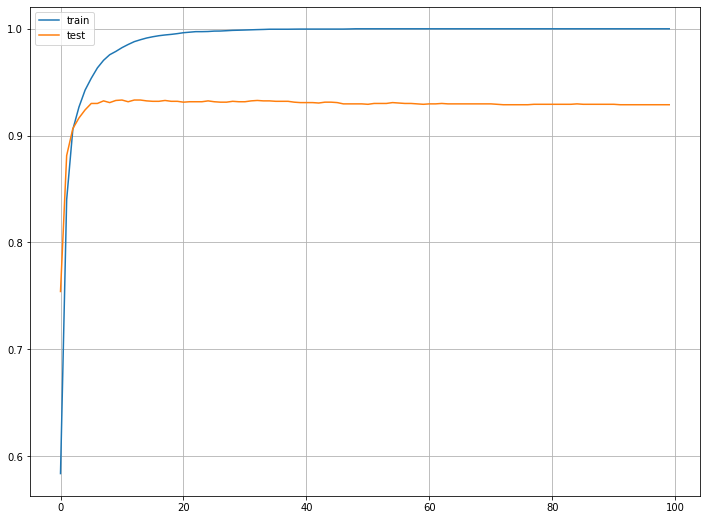

In [225]:
acc_hist = np.array(acc_hist)

plt.plot(acc_hist[:, 0], label="train")
plt.plot(acc_hist[:, 1], label="test")
plt.grid()
plt.legend()
plt.show()

## Keras

**Keras** - высокоуровневая надстройка над Tensorflow для программирования нейронных сетей. Делает работу с нейронными сетями и tensorflow значительно проще.

In [3]:
# Для чистоты, снова загрузим сырые данные
from tensorflow.keras.datasets import mnist

(X_t, y_t), (X_v, y_v) = mnist.load_data()
X_t = X_t / 255
X_v = X_v / 255

(60000, 28, 28)


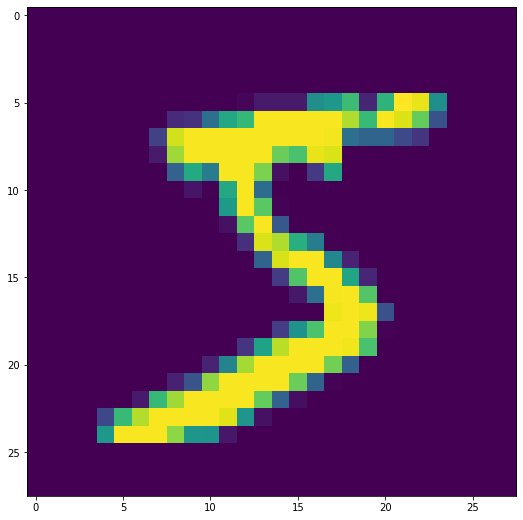

In [5]:
print(X_t.shape)
plt.imshow(X_t[0])

## Последовательный стиль

При данном подходе мы просто создаем последовательно необходимые слои друг за другом

In [5]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
model = Sequential([
    Flatten(),
    Dense(30, activation=tf.nn.relu),
    Dense(10, activation="softmax")
])

# А могли просто по порядку вызывать add
#model.add(Dense(30))

model.compile(optimizer="adam", 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_t, y_t, epochs=50, verbose=2, validation_data=(X_v, y_v));

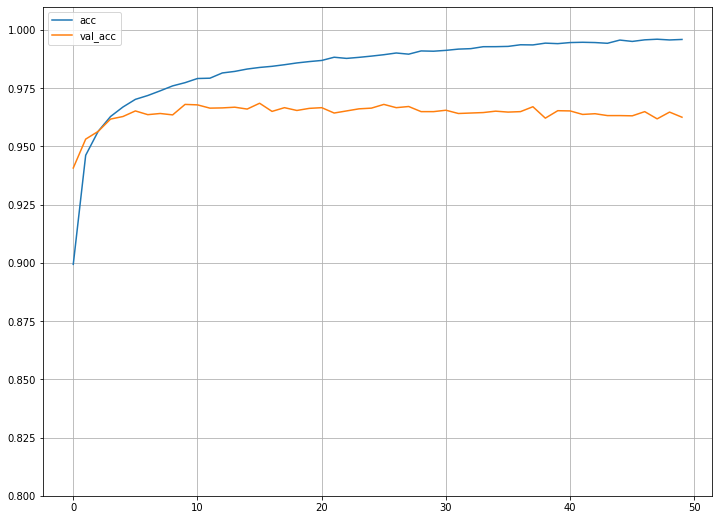

In [232]:
plt.plot(history.history['accu racy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.ylim([0.8, 1.01])
plt.show()

In [233]:
# Ничего не мешает нам потом использовать модель для расчета конкретных результатов
test_loss, test_acc = model.evaluate(X_v, y_v)

print(test_loss, test_acc)

10000/10000 [==============================] - 1s 147us/sample - loss: 0.1957 - accuracy: 0.9625
0.19567294678930994 0.9625


## Функциональный стиль

В данном стиле мы сами соединяем все элементы сети. Позволяет создавать более сложные структуры сети.

In [236]:
# Вход
inputs = tf.keras.Input(shape=(28, 28))
flat = tf.keras.layers.Flatten()(inputs)

# Скрытый слой слой
x = tf.keras.layers.Dense(30, activation=tf.nn.relu)(flat)
# Вывод
outputs = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(x)

# Модель
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_t, y_t, epochs=10, verbose=2, validation_data=(X_v, y_v));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 12s - loss: 0.3711 - accuracy: 0.8946 - val_loss: 0.2049 - val_accuracy: 0.9406
Epoch 2/10
60000/60000 - 6s - loss: 0.1856 - accuracy: 0.9454 - val_loss: 0.1623 - val_accuracy: 0.9528
Epoch 3/10
60000/60000 - 6s - loss: 0.1468 - accuracy: 0.9570 - val_loss: 0.1449 - val_accuracy: 0.9569
Epoch 4/10
60000/60000 - 6s - loss: 0.1247 - accuracy: 0.9630 - val_loss: 0.1302 - val_accuracy: 0.9606
Epoch 5/10
60000/60000 - 6s - loss: 0.1099 - accuracy: 0.9664 - val_loss: 0.1170 - val_accuracy: 0.9644
Epoch 6/10
60000/60000 - 7s - loss: 0.0983 - accuracy: 0.9695 - val_loss: 0.1161 - val_accuracy: 0.9640
Epoch 7/10
60000/60000 - 7s - loss: 0.0893 - accuracy: 0.9719 - val_loss: 0.1223 - val_accuracy: 0.9622
Epoch 8/10
60000/60000 - 7s - loss: 0.0819 - accuracy: 0.9754 - val_loss: 0.1227 - val_accuracy: 0.9625
Epoch 9/10
60000/60000 - 7s - loss: 0.0765 - accuracy: 0.9763 - val_loss: 0.1177 - val_accuracy: 0.9667
Epoch 10/10
6

## Сохранение

В Keras присутствует удобный механизм для сохранения моделей

In [ ]:
# Можно создать коллбэк, который позволит сохранять промежуточные состояния нейронной сети
# Мы выбираем сохранять только наилучшую модель

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt",
                                                 save_best_only=True,
                                                 monitor='val_accuracy', mode='max',
                                                 save_weights_only=True,
                                                 verbose=1)

model = Sequential([
    Flatten(),
    Dense(30, activation=tf.nn.relu),
    Dense(10, activation="softmax")
])

model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_t, y_t, epochs=50, verbose=2, 
                    validation_data=(X_v, y_v),callbacks=[cp_callback]);

In [8]:
np.max(history.history['val_accuracy'])

0.9683

In [9]:
model.load_weights("checkpoint.ckpt")
model.evaluate(X_v, y_v)

10000/10000 [==============================] - 1s 71us/sample - loss: 0.1134 - accuracy: 0.9683


[0.11342877514463616, 0.9683]

In [10]:
# А можно просто сохранить модель

model.save('manual.ckpt')
loaded_model = keras.models.load_model('manual.ckpt')
loaded_model.evaluate(X_v, y_v)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: manual.ckpt/assets
10000/10000 [==============================] - 1s 76us/sample - loss: 0.1134 - accuracy: 0.9683


[0.11342920236540958, 0.9683]

## Автокодировщики

В простейшем случае - это обычный многослойные персептрон, у которого число входов совпадает с числом выходом. При этом при обучении, мы обучаем сеть так, чтобы воспроизводить данные полученные на входе.

<center>
    <img src="ae.png">
</center>

## Для чего?

* предобучение нейронных сетей
* компрессия данных
* сглаживание данных
* формирование признаков

Почитать обзор с примерами можно __[здесь](https://habr.com/ru/post/331382/)__ 

In [11]:
# Кодировщик
inputs = tf.keras.Input(shape=(28, 28))
flat = Flatten()(inputs)
encoded = Dense(49, activation='relu')(flat)

encoder = tf.keras.Model(inputs, encoded, name="encoder")

# Декодер
input_decoder = tf.keras.Input(shape=(49,))
decoded = Dense(784, activation='sigmoid')(input_decoder)
output = tf.keras.layers.Reshape((28, 28))(decoded)

decoder = tf.keras.Model(input_decoder, output, name="decoder")

# Автокодировщик
autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)), name="autoencoder")

In [12]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
encoder (Model)              (None, 49)                38465     
_________________________________________________________________
decoder (Model)              (None, 28, 28)            39200     
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.compile(optimizer=tf.optimizers.Adam(), 
                    loss='binary_crossentropy')
autoencoder.fit(X_t, X_t, epochs=10, verbose=1);

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 223us/sample - loss: 0.1456
Epoch 2/10
60000/60000 [==============================] - 9s 155us/sample - loss: 0.0896
Epoch 3/10
60000/60000 [==============================] - 10s 163us/sample - loss: 0.0825
Epoch 4/10
60000/60000 [==============================] - 10s 172us/sample - loss: 0.0810
Epoch 5/10
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0804
Epoch 6/10
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0801
Epoch 7/10
60000/60000 [==============================] - 9s 150us/sample - loss: 0.0799
Epoch 8/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.0797
Epoch 9/10
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0796
Epoch 10/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0795


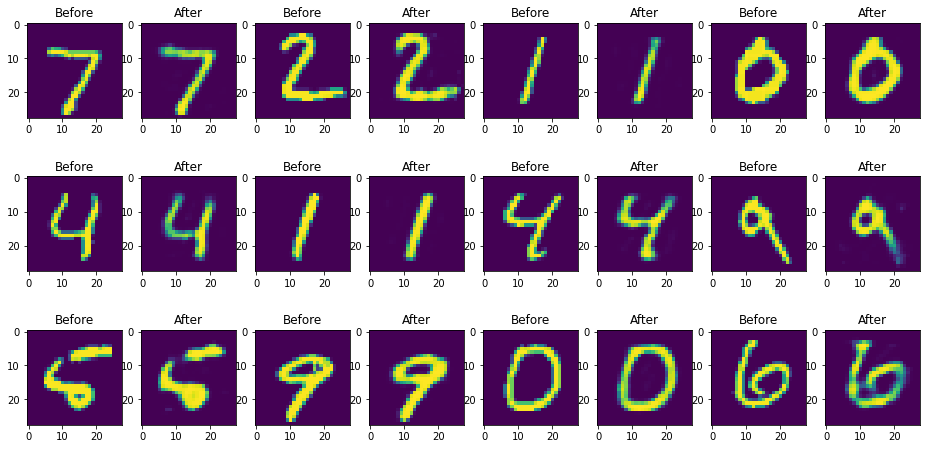

In [14]:
X_p = autoencoder.predict(X_v[:30])

plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(3, 8, 1 + 2 * i)
    plt.title("Before")
    plt.imshow(X_v[i].reshape((28, 28)))
    plt.subplot(3, 8, 1 + 2 * i + 1)
    plt.title("After")
    plt.imshow(X_p[i].reshape((28, 28)))
    
plt.show()

In [15]:
enc = encoder.predict(X_v)
enc.shape

(10000, 49)

Можно обучить автокодировщик для убирания шума.

In [17]:
X_n = X_t + np.random.normal(0.5, 0.5, X_t.shape)
X_n = np.clip(X_n, 0, 1)
autoencoder.compile(optimizer=tf.optimizers.Adam(), 
                    loss='binary_crossentropy')
autoencoder.fit(X_n, X_t, epochs=10);

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 285us/sample - loss: 0.1627
Epoch 2/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.1344
Epoch 3/10
60000/60000 [==============================] - 11s 177us/sample - loss: 0.1305
Epoch 4/10
60000/60000 [==============================] - 12s 194us/sample - loss: 0.1290
Epoch 5/10
60000/60000 [==============================] - 10s 166us/sample - loss: 0.1282
Epoch 6/10
60000/60000 [==============================] - 9s 152us/sample - loss: 0.1277
Epoch 7/10
60000/60000 [==============================] - 11s 180us/sample - loss: 0.1273
Epoch 8/10
60000/60000 [==============================] - 10s 174us/sample - loss: 0.1270
Epoch 9/10
60000/60000 [==============================] - 10s 171us/sample - loss: 0.1268
Epoch 10/10
60000/60000 [==============================] - 10s 160us/sample - loss: 0.1266


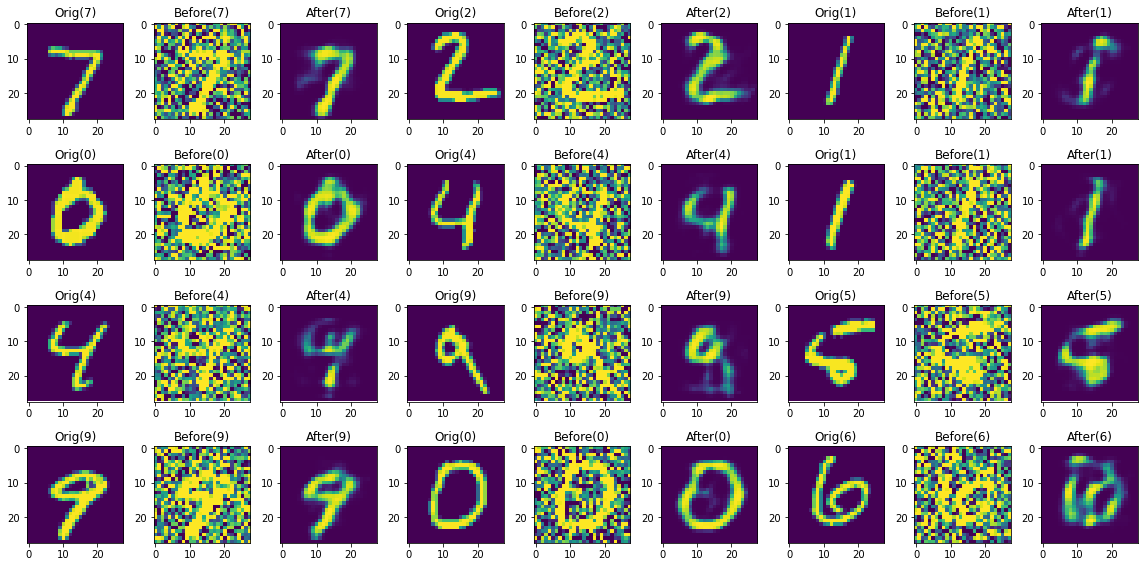

In [18]:
X_i = X_v[:30] + np.random.normal(0.5, 0.5, X_v[:30].shape)
X_i = np.clip(X_i, 0, 1)
X_p = autoencoder.predict(X_i)

plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(4, 9, 1 + 3 * i)
    plt.title("Orig(%d)" % y_v[i])
    plt.imshow(X_v[i])
    
    plt.subplot(4, 9, 1 + 3 * i + 1)
    plt.title("Before(%d)" % y_v[i])
    plt.imshow(X_i[i])
    
    plt.subplot(4, 9, 1 + 3 * i + 2)
    plt.title("After(%d)" % y_v[i])
    plt.imshow(X_p[i])
plt.tight_layout()    
plt.show()

## Сверточные сети

**Convolution Neural Network** - это специальная архитектура нейронных сетей, называемая так благодаря использованию операции свертки

<center>
    <img src="cat.png">
</center>

## Свертка

Это довольно простая операция, активно используемая цифровыми фильтрами.

$$
y_{i, j} = \sum_{k, m} \omega_{k,m} x_{i+k, j+m}
$$

где $\omega$ - коэффициенты ядра свертки

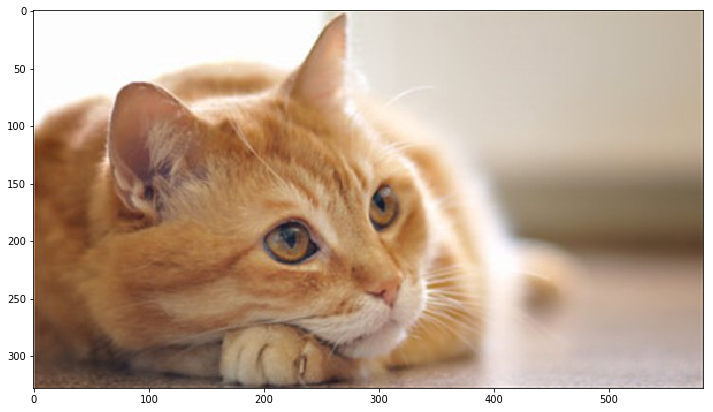

In [48]:
from scipy import ndimage

img = ndimage.imread("../img/cat.jpeg")
img = img / 255
plt.imshow(img);

Рассмотрим простое ядро

In [49]:
K = np.array(
    [[ -1, -1, -1],
     [ -1,  8, -1],
     [ -1, -1, -1]],
)

In [50]:
new_img = np.zeros(img.shape)

new_img[:,:,0] = ndimage.convolve(img[:,:,0], K, mode='constant', cval=0.0)
new_img[:,:,1] = ndimage.convolve(img[:,:,1], K, mode='constant', cval=0.0)
new_img[:,:,2] = ndimage.convolve(img[:,:,2], K, mode='constant', cval=0.0)

new_img = np.clip(new_img, 0, 1)

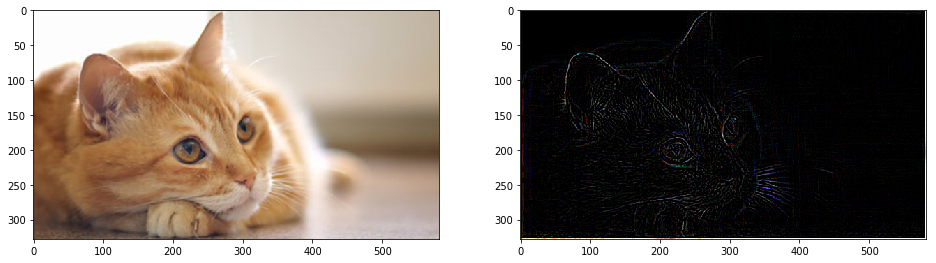

In [51]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(new_img)
plt.show()

А теперь вернемся к нейронным сетям. Представим входное изображение в виде матрицы входных нейронов.
<center>
    <img src="tikz42.png">
</center>

Дальше ядром проходим по всем нейронам, свертка с которым становится входным значением для нейронов следующего слоя. При этом ядро используется везде одно и тоже.

<center>
    <img src="tikz44.png">
</center>

<center>
    <img src="tikz45.png">
</center>

Если у нас было изображение 28х28, то после свертки с ядром 5х5, мы получим матрицу значений 24х24. Сигнал нейрона в следующем слое можно представить как:

$$
y_{i,j} = \sum_{m,n} \omega_{m, n} y_{i+m, j+n} + b
$$

Фактически, мы пытаемся обнаружить некий признак, который соответвует ядру свертки. В результате получая карту признака (feature map). Основным преимуществом является то, что при этом не очень важно где на изображении находится искомый признак.

<center>
    <img src="filter.png">
</center>

<center>
    <img src="mice.png">
</center>

<center>
    <img src="part1.png">
</center>

<center>
    <img src="part2.png">
</center>

И ничего не мешает взять несколько ядер

<center>
    <img src="tikz46.png">
</center>

Такой подход значительно уменьшает количество настраиваемых параметров. Для сравнения, в примере выше на одну признаковую карту уходит 26 параметров. Для полносвязной сети со скрытым слоем из 30 нейронов уходило бы 23550 параметров.

## Слои подвыборки

**Pooling layer** - позволяет уменьшить размерность данных. Применяется после сверточного слоя. По факту - это просто скользящее окно с какой-то агрегирующей функцией (обычно avg или max).

<center>
    <img src="poolingmax.png">
</center>

<center>
    <img src="poolingaverage.png">
</center>

Таким образом, при использовании окна 2х2, после pooling layer из 24х24 остается матрица 12х12.

## LeNet-5

Попробуем реализовать одну из популярных нейронных сетей для распознования рукописных цифр - __[LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)__

<center>
    <img src="lenet5.png">
</center>

In [6]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten

model = Sequential()

# Первый сверточный блок
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(32, 32, 1)))
model.add(AveragePooling2D((2, 2)))

# Второй сверточный блок
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu'))
model.add(AveragePooling2D((2, 2)))

# Разворачиваем изображение в вектор
model.add(Flatten())

# Полносвязные слои
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [8]:
# Подготавливаем данные для входа на сверточный слой
X_prep = X_t.reshape((-1, 28, 28, 1))
X_prep = np.pad(X_prep, ((0,0),(2,2),(2,2),(0,0)), 'constant') / 255

X_prep_v = X_v.reshape((-1, 28, 28, 1))
X_prep_v = np.pad(X_prep_v, ((0,0),(2,2),(2,2),(0,0)), 'constant') / 255

In [9]:
%%time

# Обучаем
model.fit(X_prep, y_t, validation_data=(X_prep_v, y_v), epochs=10, verbose=1);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 500us/sample - loss: 0.7438 - accuracy: 0.7476 - val_loss: 0.3208 - val_accuracy: 0.9015
Epoch 2/10
60000/60000 [==============================] - 29s 482us/sample - loss: 0.2552 - accuracy: 0.9196 - val_loss: 0.1955 - val_accuracy: 0.9409
Epoch 3/10
60000/60000 [==============================] - 30s 495us/sample - loss: 0.1787 - accuracy: 0.9436 - val_loss: 0.1518 - val_accuracy: 0.9530
Epoch 4/10
60000/60000 [==============================] - 36s 594us/sample - loss: 0.1409 - accuracy: 0.9556 - val_loss: 0.1155 - val_accuracy: 0.9623
Epoch 5/10
60000/60000 [==============================] - 35s 583us/sample - loss: 0.1161 - accuracy: 0.9642 - val_loss: 0.0996 - val_accuracy: 0.9670
Epoch 6/10
60000/60000 [==============================] - 30s 497us/sample - loss: 0.1009 - accuracy: 0.9685 - val_loss: 0.0880 - val_accuracy: 0.9732
Epoch 7/10
60000/60000 [====================

In [14]:
model.evaluate(X_prep_v, y_v)

10000/10000 [==============================] - 2s 250us/sample - loss: 0.0665 - accuracy: 0.9793


[0.06646945488667115, 0.9793]

In [15]:
# Сохраняем модель целиком в один файл формата HDF5
model.save('lanet5.h5')

In [16]:
# Восстаналиваем ту же самую модель, включая веса и оптимизатор
model = tf.keras.models.load_model('lanet5.h5')

In [17]:
def plot_conv_weights(model, layer_name, channel=0):
    W = model.get_layer(name=layer_name).get_weights()[0]
    plt.figure()
    rows = int(W.shape[-1] / 5) + 1
    for i in range(W.shape[-1]):
        plt.subplot(rows, 5, i + 1)
        plt.imshow(W[:,:,channel, i])
    plt.tight_layout()
    plt.show()

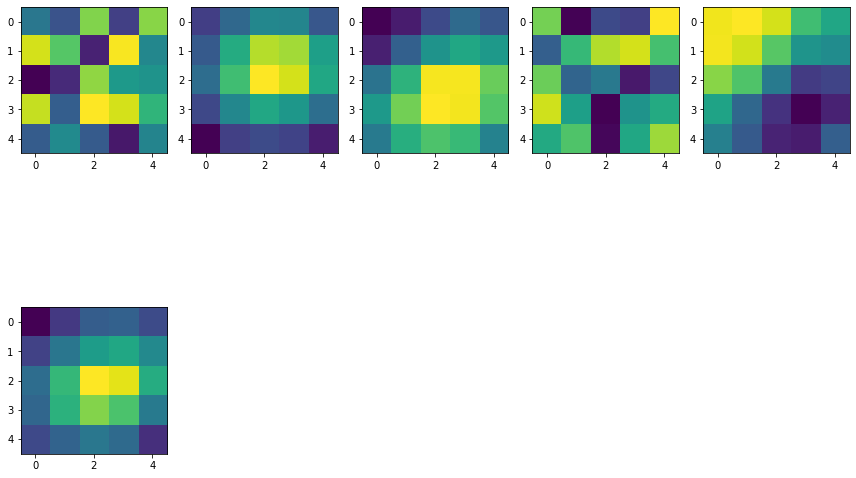

In [18]:
plot_conv_weights(model, 'conv2d')

## Рекуррентные нейронные сети

**Reccurent Neural Network** - достаточно интересный вид нейронных сетей, в который каждый нейрон получает сигнал с собственного выхода, но с задержкой.

В простейшем виде реккурентный нейрон можно представить так
<center>
    <img src="rnn.jpg">
</center>

Формульно это запишеться как (один из вариантов)

$$
\vec{o}_t = f_o(\mathbf{V} \, \vec{s}_t) \\
\vec{s}_t = f_s(\mathbf{W} \, \vec{s}_{t-1} + \mathbf{U} \, \vec{x}_t)
$$

как же это обучать?

а все так же, обратным распространение ошибки, но во времени (Backpropagation Through Time)

Для чего можно использовать

* анализ последовательностей
* анализ и синтез речи
* анализ текстов
* фильтры
* и много другое

## LSTM

**Long short-term memory** - долгая краткосрочная память, умеет отслеживать события, что разнесены на достаточно большом промежутке времени. 

Отличается от предыдущего случая введением вектора внутреннего состояния $C_t$

### Обычный RNN

<center>
    <img src="rnn0.png">
</center>

### LSTM

<center>
    <img src="lstm.png">
</center>

<center>
    <img src="lstm-notation.png">
</center>

## Forget gate

Вентиль забывания - решает какие данные стоит забыть из прошлого

<center>
    <img src="lstm-forget.png">
</center>

## Input gate

Вентиль входных данных - решает, какие данные нужно обновить

<center>
    <img src="lstm-input.png">
</center>

Формируем новое состояние

<center>
    <img src="lstm-new.png">
</center>

## Output gate

Вентиль выходных данных - решает, что необходимо показать на выходе

<center>
    <img src="lstm-output.png">
</center>

## Пример

In [19]:
df = pd.read_csv("../data/AirPassengers.csv", index_col="Month", parse_dates=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


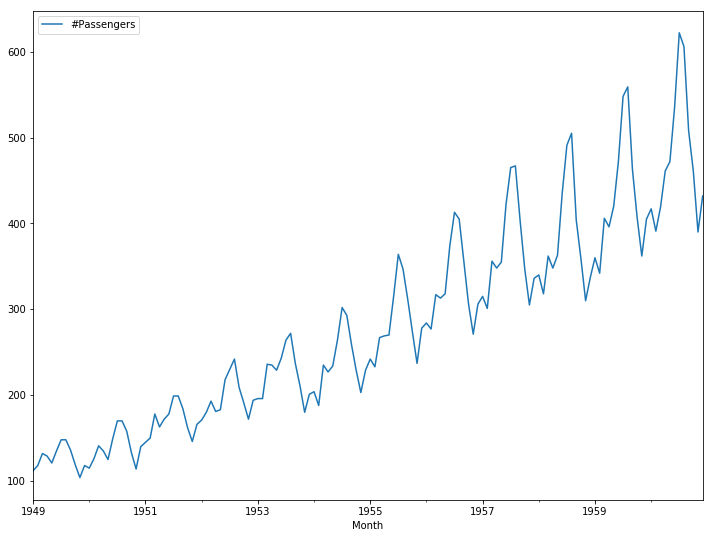

In [75]:
df.plot();

In [76]:
from tensorflow.keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [128]:
scaler = MinMaxScaler(feature_range=(0, 1))

data = df.values.astype('float32')
data = scaler.fit_transform(data)

M = int(0.67 * data.shape[0])
train, test = data[:M], data[M:]

In [79]:
def convert(data, look_back=1):
    dataX, dataY = [], []
    for i in range(data.shape[0] - look_back):
        a = data[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

look_back = 12

X_t, y_t = convert(train, look_back)
X_v, y_v = convert(test, look_back)

print(X_t[0], y_t[0])
print(X_t[1], y_t[1])
print(X_t[2], y_t[2])

[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753 0.         0.02702703] 0.021235526
[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
 0.08494207 0.06177607 0.02895753 0.         0.02702703 0.02123553] 0.042471036
[0.05405405 0.04826255 0.03281853 0.05984557 0.08494207 0.08494207
 0.06177607 0.02895753 0.         0.02702703 0.02123553 0.04247104] 0.07142857


In [80]:
# LSTM принимает данные в виде (samples, time_serises, features)

X_t = np.reshape(X_t, (X_t.shape[0], X_t.shape[1], 1))
X_v = np.reshape(X_v, (X_v.shape[0], X_v.shape[1], 1))

In [82]:
tf.keras.optimizers.Adam?

In [ ]:
model = Sequential()

model.add(LSTM(32, input_shape=(look_back, 1), return_sequences=False))
#model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
model.fit(X_t, y_t, epochs=2000, verbose=2)

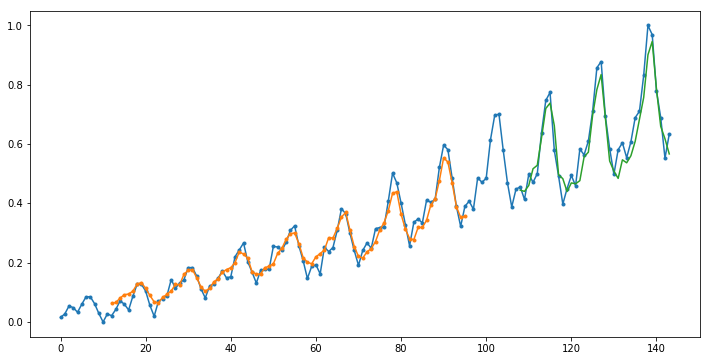

In [104]:
plt.figure(figsize=(12,6))
plt.plot(data, ".-")

X_1 = model.predict(X_t)
plt.plot(np.arange(look_back, look_back + X_1.shape[0]), X_1.ravel(), ".-")

X_2 = model.predict(X_v)
plt.plot(np.arange(2 * look_back + X_1.shape[0], 
                   2 * look_back + X_1.shape[0] + X_2.shape[0]), X_2.ravel())
plt.show()

## Анализ отзывов IMDB 

In [8]:
from tensorflow.keras.datasets import imdb
import tensorflow as tf

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000,
)

In [15]:
print(len(train_data), 'train sequences')
print(len(train_labels), 'test sequences')
print(len(train_data[0]), "train sequences [0]")

25000 train sequences
25000 test sequences
218 train sequences [0]


In [4]:
word_index = imdb.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[123]])

print(decoded_review)

? beautiful and touching movie rich colors great settings good acting and one of the most charming movies i have seen in a while i never saw such an interesting setting when i was in china my wife liked it so much she asked me to ? on and rate it so other would enjoy too


In [10]:
# Приводим последовательности к одной длине
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=80)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=80)

In [16]:
x_train[0].shape

(80,)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, train_labels,
          batch_size=32,
          epochs=15,
          validation_data=(x_test, test_labels))

In [23]:
score, acc = model.evaluate(x_test, test_labels,
                            batch_size=32)
print('Test loss:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 17s 699us/sample - loss: 1.0121 - accuracy: 0.8198
Test loss: 1.0121408461940289
Test accuracy: 0.81976
